<a href="https://colab.research.google.com/github/lazarussim12-beep/DLI_GRP_Assignment/blob/main/Lazarus%20method%20version%206.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import all required library


In [4]:
import time
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

import lightgbm as lgb

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM, Dropout, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC

import xgboost as xgb
import lightgbm as lgb
import pickle



# Import Dataset


--2025-08-01 06:14:34--  https://github.com/lazarussim12-beep/DLI_GRP_Assignment/raw/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lazarussim12-beep/DLI_GRP_Assignment/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip [following]
--2025-08-01 06:14:34--  https://raw.githubusercontent.com/lazarussim12-beep/DLI_GRP_Assignment/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15642124 (15M) [application/zip]
Saving to: ‘enron_spam_data.zip.1’

enron_spam_data.zip 100%

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14



Column names: ['Message ID', 'Subject', 'Message', 'Spam/Ham', 'Date']

=== SPAM vs HAM Analysis ===
Using column: 'Spam/Ham'
Counts by category:
Spam/Ham
spam    17171
ham     16545
Name: count, dtype: int64

Percentages by category:
spam: 50.93%
ham: 49.07%

Detailed Analysis:
Total emails: 33716
ham: 16545 emails (49.07%)
spam: 17171 emails (50.93%)


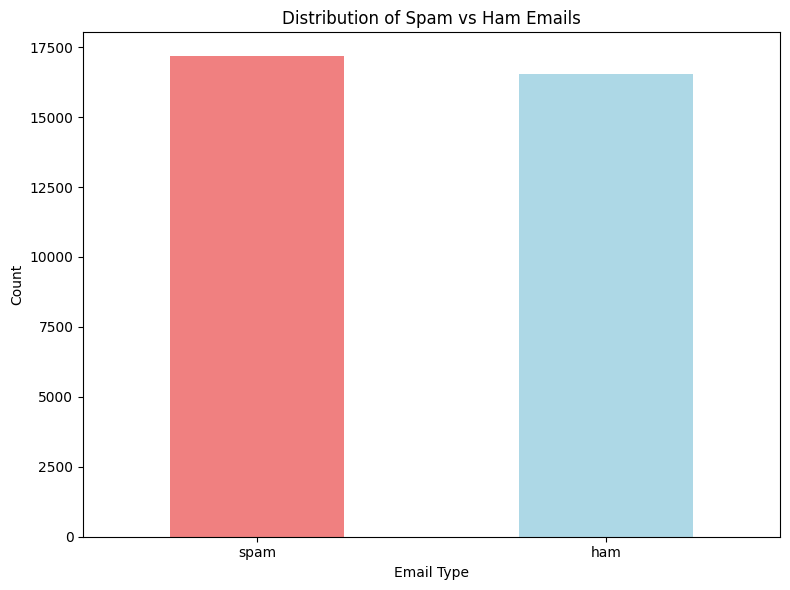

In [5]:
# Download the zip file from GitHub
!wget https://github.com/lazarussim12-beep/DLI_GRP_Assignment/raw/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip

# Unzip the file
import zipfile
with zipfile.ZipFile('enron_spam_data.zip', 'r') as zip_ref:
    zip_ref.extractall('enron_data')

# List extracted files (to verify)
import os
extracted_files = os.listdir('enron_data')
print("Extracted files:", extracted_files)

# Load the CSV file(s) into pandas
import pandas as pd

for file in extracted_files:
    if file.endswith('.csv'):
        df = pd.read_csv(f'enron_data/{file}')
        print(f"Loaded {file} with shape:", df.shape)

        # Display first few rows
        display(df.head())

        print(f"\nColumn names: {df.columns.tolist()}")

        # Calculate number of spam and ham in the Spam/Ham column
        print("\n=== SPAM vs HAM Analysis ===")

        spam_col = None
        for col in df.columns:
            if 'spam' in col.lower() or 'ham' in col.lower():
                spam_col = col
                break

        if spam_col is None:
            spam_col = df.columns[3] if len(df.columns) > 3 else df.columns[-1]

        print(f"Using column: '{spam_col}'")

        # Count values in the spam/ham column
        spam_ham_counts = df[spam_col].value_counts()
        print("Counts by category:")
        print(spam_ham_counts)

        # Calculate percentages
        spam_ham_percentages = df[spam_col].value_counts(normalize=True) * 100
        print("==========================")
        print("\nPercentages by category:")
        for category, percentage in spam_ham_percentages.items():
            print(f"{category}: {percentage:.2f}%")

        # More detailed analysis
        total_emails = len(df)
        print("==========================")
        print(f"\nDetailed Analysis:")
        print(f"Total emails: {total_emails}")

        for category in df[spam_col].unique():
            count = (df[spam_col] == category).sum()
            percentage = (count / total_emails) * 100
            print(f"{category}: {count} emails ({percentage:.2f}%)")

        try:
            import matplotlib.pyplot as plt

            plt.figure(figsize=(8, 6))
            spam_ham_counts.plot(kind='bar', color=['lightcoral', 'lightblue'])
            plt.title('Distribution of Spam vs Ham Emails')
            plt.xlabel('Email Type')
            plt.ylabel('Count')
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()

        except ImportError:
            print("\nMatplotlib not available for visualization")

        break

# Lazarus Sim Wen Hui Code


In [6]:
df['Message'] = df['Message'].astype(str).str.lower().apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
df['Spam/Ham'] = df['Spam/Ham'].map({'ham': 0, 'spam': 1})
X = df['Message'].values
y = df['Spam/Ham'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tokenization and padding
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# CNN feature extractor model (CNN only, no LSTM)
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    Dropout(0.3),
    Conv1D(64, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train CNN feature extractor
start_time = time.time()
model.fit(
    X_train_seq, y_train,
    batch_size=32,
    epochs=5,
    validation_split=0.1,
    verbose=2
)

# Extract CNN features (output from GlobalMaxPooling1D layer)
feature_extractor = Model(inputs=model.layers[0].input, outputs=model.layers[4].output)
X_train_cnn_feat = feature_extractor.predict(X_train_seq)
X_test_cnn_feat = feature_extractor.predict(X_test_seq)

# TF-IDF features with n-grams
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression on TF-IDF
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
proba_lr = lr.predict_proba(X_test_tfidf)[:, 1]

# Logistic Regression on CNN features
lr_cnn_only = LogisticRegression(max_iter=1000)
lr_cnn_only.fit(X_train_cnn_feat, y_train)
proba_cnn = lr_cnn_only.predict_proba(X_test_cnn_feat)[:, 1]

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_tfidf, y_train)
proba_xgb = xgb_model.predict_proba(X_test_tfidf)[:, 1]

# LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train_tfidf, y_train)
proba_lgb = lgb_model.predict_proba(X_test_tfidf)[:, 1]

# --- Soft Voting Ensemble (XGB+LGB+CNN+LR only) ---
ensemble_soft_no_rf_proba = (proba_xgb + proba_lgb + proba_cnn + proba_lr) / 4
ensemble_soft_no_rf_pred = (ensemble_soft_no_rf_proba > 0.5).astype(int)
acc_ensemble_soft_no_rf = accuracy_score(y_test, ensemble_soft_no_rf_pred)
report_ensemble_soft_no_rf = classification_report(y_test, ensemble_soft_no_rf_pred, target_names=['Ham', 'Spam'], output_dict=True)
f1_ham_ensemble_soft_no_rf = report_ensemble_soft_no_rf['Ham']['f1-score']
f1_spam_ensemble_soft_no_rf = report_ensemble_soft_no_rf['Spam']['f1-score']
avg_f1_ensemble_soft_no_rf = (f1_ham_ensemble_soft_no_rf + f1_spam_ensemble_soft_no_rf) / 2

# Print the results table with F1 scores and average F1
print("\nResults Table:")
print("+-----------------------------------------------+----------+----------+----------+----------+")
print("| Model                                         | Accuracy | F1 Ham   | F1 Spam  | Avg F1   |")
print("+-----------------------------------------------+----------+----------+----------+----------+")
print(f"| Ensemble (XGB+LGB+CNN+LR, Soft Vote)          |   {acc_ensemble_soft_no_rf:.2f}   |  {f1_ham_ensemble_soft_no_rf:.2f}   |  {f1_spam_ensemble_soft_no_rf:.2f}   |  {avg_f1_ensemble_soft_no_rf:.2f}   |")
print("+-----------------------------------------------+----------+----------+----------+----------+")
print("XGB: XGBoost \n LGB: LightGBM \n CNN: Convolutional neural network \n LR: Logistic regression")

time_taken = time.time() - start_time
minutes = int(time_taken // 60)
seconds = time_taken % 60
print(f"\nTotal runtime: {time_taken:.2f} seconds ({minutes} minutes {seconds:.2f} seconds)")

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


759/759 - 10s - 13ms/step - accuracy: 0.9204 - loss: 0.1740 - val_accuracy: 0.9763 - val_loss: 0.0674
Epoch 2/5
759/759 - 3s - 4ms/step - accuracy: 0.9841 - loss: 0.0467 - val_accuracy: 0.9755 - val_loss: 0.0652
Epoch 3/5
759/759 - 5s - 7ms/step - accuracy: 0.9913 - loss: 0.0265 - val_accuracy: 0.9763 - val_loss: 0.0702
Epoch 4/5
759/759 - 3s - 3ms/step - accuracy: 0.9930 - loss: 0.0197 - val_accuracy: 0.9804 - val_loss: 0.0628
Epoch 5/5
759/759 - 5s - 7ms/step - accuracy: 0.9945 - loss: 0.0174 - val_accuracy: 0.9804 - val_loss: 0.0785
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:15:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 13736, number of negative: 13236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.652178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 917311
[LightGBM] [Info] Number of data points in the train set: 26972, number of used features: 9970
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509269 -> initscore=0.037080
[LightGBM] [Info] Start training from score 0.037080

Results Table:
+-----------------------------------------------+----------+----------+----------+----------+
| Model                                         | Accuracy | F1 Ham   | F1 Spam  | Avg F1   |
+-----------------------------------------------+----------+----------+----------+----------+
| Ensemble (XGB+LGB+CNN+LR, Soft Vote)          |   0.99   |  0.99   |  0.99   |  0.99   |
+-----------------------------------------------+--

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# Khoo Zi Ming Code

In [ ]:
import os
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Preprocessing with lemmatization, removing stopwords and punctuation
def preprocess(text):
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.like_num:
            lemma = token.lemma_.strip()
            if lemma:
                tokens.append(lemma)
    return " ".join(tokens)

# Load CSV
csv_files = [f for f in os.listdir('enron_data') if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError("No CSV file found in 'enron_data' folder.")
df = pd.read_csv(f'enron_data/{csv_files[0]}')

# Combine subject and message
if 'Subject' not in df.columns or 'Message' not in df.columns:
    raise KeyError("Expected columns 'Subject' and 'Message' not found in the CSV.")
df['Subject'] = df['Subject'].fillna('')
df['Message'] = df['Message'].fillna('')
df['text'] = df['Subject'] + ' ' + df['Message']

# Detect label column
label_col = None
for col in df.columns:
    if 'spam' in col.lower() or 'ham' in col.lower():
        label_col = col
        break
if label_col is None:
    label_col = df.columns[3]
print(f"Using label column: {label_col}")

# Label mapping
df['label'] = df[label_col].map({'spam': 1, 'ham': 0})
df = df.dropna(subset=['label'])

# Apply preprocessing
print("Preprocessing text...")
df['cleaned_text'] = df['text'].astype(str).apply(preprocess)

# TF-IDF Vectorization
print("Vectorizing with TF-IDF...")
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naive Bayes model
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Using label column: Spam/Ham
Preprocessing text...
Vectorizing with TF-IDF...
F1 Score: 0.9708571428571429

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      3276
           1       0.96      0.98      0.97      3468

    accuracy                           0.97      6744
   macro avg       0.97      0.97      0.97      6744
weighted avg       0.97      0.97      0.97      6744



# Lee Jing Wei Code

In [ ]:
import os
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm

# Load spaCy model with only tokenizer and tagger (faster)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# Error handling for missing folder or file
if not os.path.exists("enron_data"):
    raise FileNotFoundError("Folder 'enron_data' not found.")

csv_files = [f for f in os.listdir("enron_data") if f.endswith(".csv")]
if not csv_files:
    raise FileNotFoundError("No CSV files found in 'enron_data'.")

df = pd.read_csv(f'enron_data/{csv_files[0]}')

# Combine and clean text columns
df['Subject'] = df.get('Subject', '').fillna('')
df['Message'] = df.get('Message', '').fillna('')
df['text'] = df['Subject'] + ' ' + df['Message']

# Detect spam/ham label column
label_col = None
for col in df.columns:
    if 'spam' in col.lower() or 'ham' in col.lower():
        label_col = col
        break
if label_col is None:
    label_col = df.columns[3]  # fallback

# Map labels to 0/1
df['label'] = df[label_col].map({'spam': 1, 'ham': 0})
df = df.dropna(subset=['label'])

# Preprocessing function using spaCy (with nlp.pipe for speed)
def preprocess_texts(texts):
    cleaned_texts = []
    for doc in tqdm(nlp.pipe(texts, batch_size=100, n_process=2), total=len(texts)):
        tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
        cleaned_texts.append(" ".join(tokens))
    return cleaned_texts

print("Preprocessing texts...")
df['clean_text'] = preprocess_texts(df['text'])

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Preprocessing texts...


100%|██████████| 33716/33716 [15:47<00:00, 35.60it/s] 


F1 Score: 0.9144755051203985

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90      3276
           1       0.88      0.95      0.91      3468

    accuracy                           0.91      6744
   macro avg       0.91      0.91      0.91      6744
weighted avg       0.91      0.91      0.91      6744



In [ ]:
from tabulate import tabulate
from termcolor import colored

# Evaluate
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_table = [[
    label,
    f"{metrics['precision']:.2f}",
    f"{metrics['recall']:.2f}",
    f"{metrics['f1-score']:.2f}",
    int(metrics['support'])
] for label, metrics in report_dict.items() if label in ['0', '1']]

# Fancy Banner
print("\n" + "="*50)
print(colored("🎯 Spam Detection Model Evaluation", "cyan", attrs=["bold"]))
print("="*50)

# Print F1 Score
print(colored(f"\n📌 Overall F1 Score: {f1:.4f}\n", "green", attrs=["bold"]))

# Table format
headers = ["Label", "Precision", "Recall", "F1-Score", "Support"]
print(tabulate(report_table, headers=headers, tablefmt="fancy_grid"))

# Optional: Print summary
print("\n" + colored("📝 Summary:", "magenta"))
print("• Label 0 → Ham (Not Spam)")
print("• Label 1 → Spam")
print("• Higher precision → fewer false positives")
print("• Higher recall → fewer false negatives")



🎯 Spam Detection Model Evaluation

📌 Overall F1 Score: 0.9145

╒═════════╤═════════════╤══════════╤════════════╤═══════════╕
│   Label │   Precision │   Recall │   F1-Score │   Support │
╞═════════╪═════════════╪══════════╪════════════╪═══════════╡
│       0 │        0.95 │     0.86 │       0.9  │      3276 │
├─────────┼─────────────┼──────────┼────────────┼───────────┤
│       1 │        0.88 │     0.95 │       0.91 │      3468 │
╘═════════╧═════════════╧══════════╧════════════╧═══════════╛

📝 Summary:
• Label 0 → Ham (Not Spam)
• Label 1 → Spam
• Higher precision → fewer false positives
• Higher recall → fewer false negatives


In [ ]:
#import os
#import pandas as pd
#from sklearn.model_selection import train_test_split
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics import classification_report, f1_score

# Automatically detect CSV file from extracted folder
##csv_files = [f for f in os.listdir('enron_data') if f.endswith('.csv')]
##df = pd.read_csv(f'enron_data/{csv_files[0]}')  # load the first CSV file

# Combine 'Subject' and 'Message' columns (ensure they exist)
##df['Subject'] = df['Subject'].fillna('')
##df['Message'] = df['Message'].fillna('')
##df['text'] = df['Subject'] + ' ' + df['Message']

# Detect spam/ham label column
##label_col = None
##for col in df.columns:
    ##if 'spam' in col.lower() or 'ham' in col.lower():
        ##label_col = col
        ##break
##if label_col is None:
    ##label_col = df.columns[3]  # fallback

# Map labels to 1 (spam) and 0 (ham)
##df['label'] = df[label_col].map({'spam': 1, 'ham': 0})
##df = df.dropna(subset=['label'])  # Remove rows with unmapped labels

# TF-IDF vectorization
##vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
##X = vectorizer.fit_transform(df['text'])
##y = df['label']

# Split into train and test
##X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree model
##clf = DecisionTreeClassifier(max_depth=10, random_state=42)
##clf.fit(X_train, y_train)

# Evaluate
##y_pred = clf.predict(X_test)
##print("F1 Score:", f1_score(y_test, y_pred))
##print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Ahmad Code


gay ass nigga

# Comparison and Graph